In [1]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

torch.__version__

'2.0.1'

In [2]:
TIME_STEP = 10  # rnn 时序步长数
INPUT_SIZE = 1  # rnn 的输入维度
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
H_SIZE = 64  # of rnn 隐藏单元个数
EPOCHS = 300  # 总共训练次数
h_state = None  # 隐藏层状态

In [3]:
steps = np.linspace(0, np.pi * 2, 256, dtype=np.float32)
x_np = np.sin(steps)
y_np = np.cos(steps)

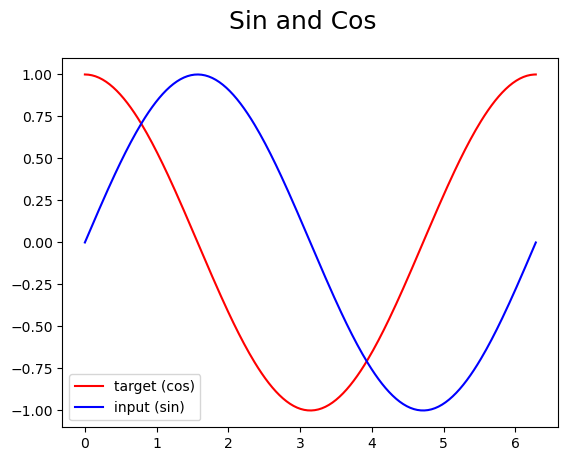

In [4]:
plt.figure(1)
plt.suptitle('Sin and Cos', fontsize='18')
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

In [5]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=H_SIZE,
            num_layers=1,
            batch_first=True,
        )
        self.out = nn.Linear(H_SIZE, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
        outs = []  # 保存所有的预测值
        for time_step in range(r_out.size(1)):  # 计算每一步长的预测值
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state
        # 也可使用以下这样的返回值
        # r_out = r_out.view(-1, 32)
        # outs = self.out(r_out)
        # return outs, h_state

In [6]:
rnn = RNN().to(DEVICE)
optimizer = torch.optim.Adam(rnn.parameters())  # Adam优化，几乎不用调参
criterion = nn.MSELoss()  # 因为最终的结果是一个数值，所以损失函数用均方误差

EPOCHS: 49,Loss:0.001305


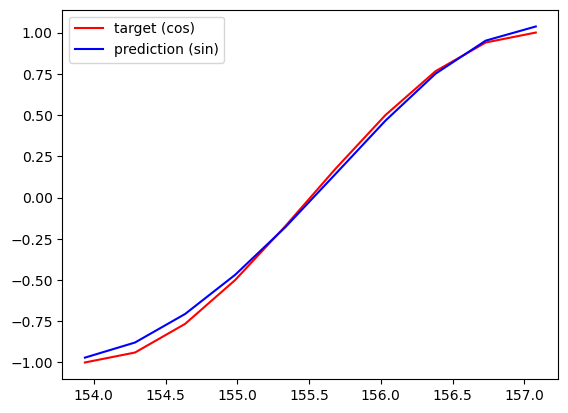

EPOCHS: 99,Loss:0.033723


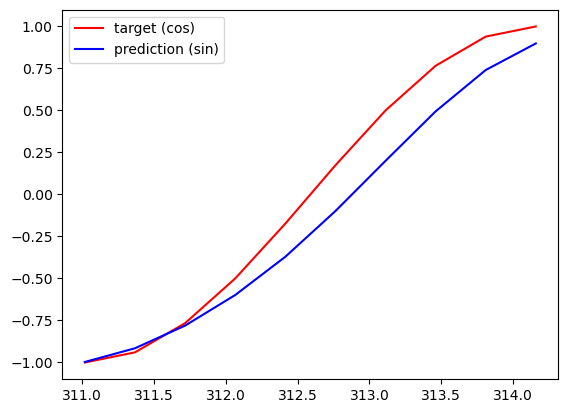

EPOCHS: 149,Loss:0.022680


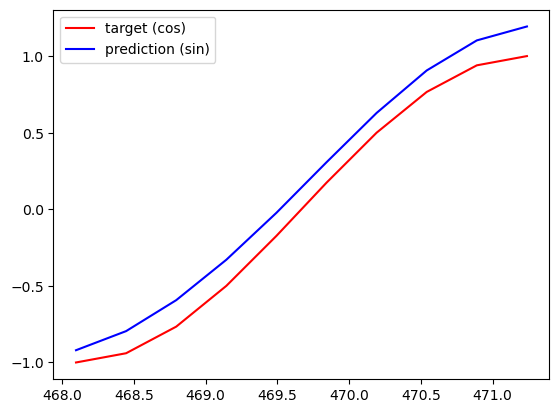

EPOCHS: 199,Loss:0.007628


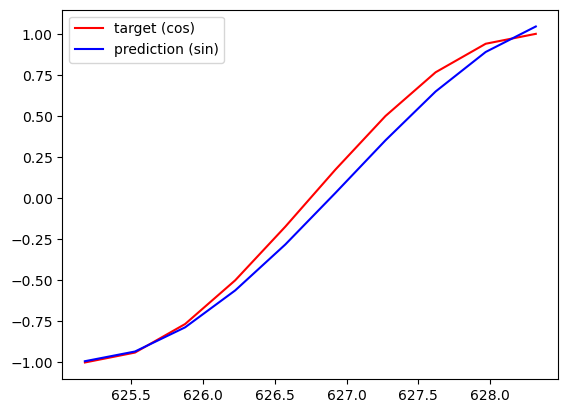

EPOCHS: 249,Loss:0.002516


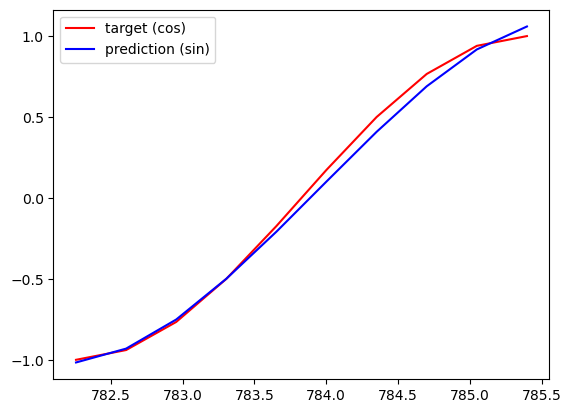

EPOCHS: 299,Loss:0.132198


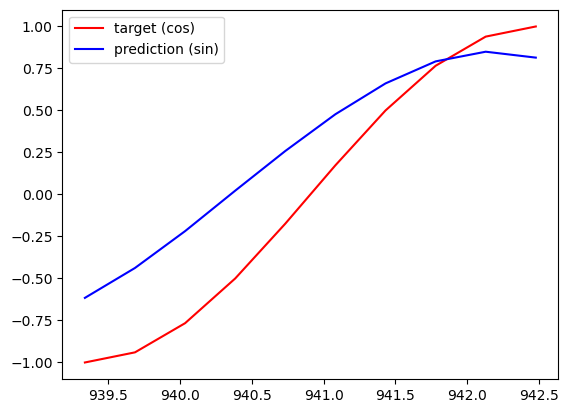

In [8]:
rnn.train()
plt.figure(2)
for step in range(EPOCHS):
    start, end = step * np.pi, (step + 1) * np.pi  # 一个时间周期
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)
    y_np = np.cos(steps)
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis]).to(DEVICE)  # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis]).to(DEVICE)
    prediction, h_state = rnn(x, h_state)  # rnn output
    # 这一步非常重要
    h_state = h_state.data  # 重置隐藏层的状态, 切断和前一次迭代的链接
    loss = criterion(prediction, y)
    # 这三行写在一起就可以
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (step + 1) % 50 == 0:  #每训练20个批次可视化一下效果，并打印一下loss
        print("EPOCHS: {},Loss:{:4f}".format(step, loss))
        plt.plot(steps, y_np.flatten(), 'r-', label='target (cos)')
        plt.plot(steps, prediction.cpu().detach().numpy().flatten(), 'b-', label='prediction (sin)')
        plt.legend(loc='best')
        plt.draw()
        plt.pause(0.01)